# Turing Target Practice

## Model

In [64]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [65]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [66]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [67]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [68]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [69]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [70]:
target = TuringTarget(stat_model);

In [71]:
spl = MCHMC(10_000, 0.5; adaptive=true, init_eps=0.07, sigma=ones(2))
samples_mchmc = Sample(spl, target, 100_000;
                       burn_in=100,
                       initial_x = [0.2, 0.8], 
                       file_name="Turing_sequential_samples",  
                       dialog=true)

[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
MCHMC (tuning):  24%|████████▌                          |  ETA: 0:00:00

Burn in step: 2000
eps --->0.02150381009055881
L   --->0.006423840480531602
 
Burn in step: 4000
eps --->0.023589766147513715
L   --->0.008707294180497352
 


MCHMC (tuning):  46%|████████████████▎                  |  ETA: 0:00:00

Burn in step: 6000
eps --->0.034060994174894194
L   --->0.01258388089712379
 


MCHMC (tuning):  67%|███████████████████████▌           |  ETA: 0:00:00

Burn in step: 8000
eps --->0.025454966887837965
L   --->0.00833014939946824
 


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:00

Burn in step: 10000
eps --->0.03163424774725576
L   --->0.00426726320120774
 


[ Info: eps: 0.03163424774725576
[ Info: L: 0.00426726320120774
[ Info: nu: 31.523571529638115
[ Info: sigma: [1.0, 1.0]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:05

100000-element Vector{Any}:
 [0.2353780583755835, 0.892520454274328, 0.03163424774725576, -0.6293899288965541, 15.85265654363602]
 [0.23226832214228718, 0.8701693228085468, 0.031681979123731316, 0.889579003329553, 16.265548209606575]
 [0.23587503238696142, 0.8519981910738812, 0.03184356990606502, 0.020727581518166005, 16.28646753428247]
 [0.23619309197433164, 0.8837599600424172, 0.03194153436191046, -0.7605595402221148, 16.032526827421098]
 [0.23543267507543988, 0.8522877555786147, 0.032037597186202374, 0.7656015749264249, 16.287712090651343]
 [0.2311351135033161, 0.8440742190628604, 0.03224403933720362, -0.10690403439261686, 16.211346893379147]
 [0.2280271355473122, 0.8671265044791403, 0.03245803639608985, 0.19728989958660392, 16.305905730007602]
 [0.2255998417819414, 0.8943339531239163, 0.0325954925218499, -0.6446645649438594, 16.003034454943894]
 [0.22176843511411368, 0.8778363007807775, 0.03277611033761429, 0.4792777399745969, 16.27850478695082]
 [0.21835324769832282, 0.89873721604

In [46]:
std(samples_mchmc)[1:end-2]

3-element Vector{Float64}:
 0.04019557604510224
 0.04316792532379128
 0.004238960181086239

In [47]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

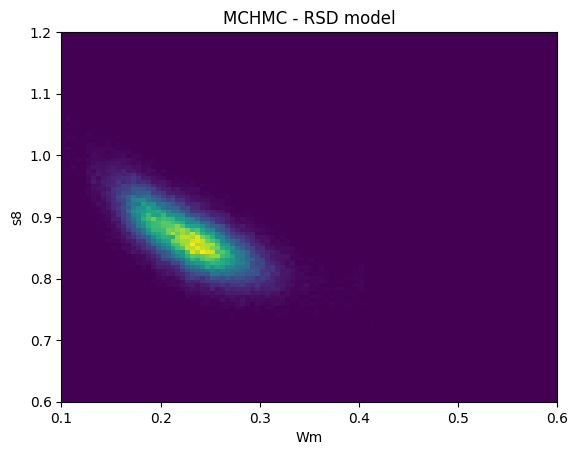

In [48]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

##  AbstractMCMC

In [85]:
spl = MCHMC(10_000, 0.5; adaptive=true, init_eps=0.07, sigma=ones(2))
samples = sample(stat_model, spl, 10_000; dialog=true, progress=true)

[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
MCHMC (tuning):  18%|██████▎                            |  ETA: 0:00:00

Burn in step: 2000
eps --->0.029642732961104364
L   --->0.00898189402363297
 


MCHMC (tuning):  36%|████████████▋                      |  ETA: 0:00:00

Burn in step: 4000
eps --->0.03293632612110807
L   --->0.01246219176947358
 


MCHMC (tuning):  54%|██████████████████▊                |  ETA: 0:00:00

Burn in step: 6000
eps --->0.023388549054799392
L   --->0.008813677688222662
 


MCHMC (tuning):  71%|█████████████████████████          |  ETA: 0:00:00

Burn in step: 8000
eps --->0.030159844915238605
L   --->0.010612271450685272
 


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:00

Burn in step: 10000
eps --->0.03082822503287472
L   --->0.005476869196800814
 


[ Info: eps: 0.03082822503287472
[ Info: L: 0.005476869196800814
[ Info: nu: 12.895590283786076
[ Info: sigma: [1.0, 1.0]
[ Info: adaptive: true
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×5×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.65 seconds
Compute duration  = 0.65 seconds
parameters        = Ωm, σ8
internals         = eps, E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm    0.2255    0.0423     0.0004    0.0041   25.9287    1.0529      ⋯
          σ8    0.8695    0.0461     0.0005    0.0036   41.7571    1.0419      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1463    0.1963    0.2250    0.2546    0.3032
          σ8    0.7889    0.8372    0.8664    0.8980    0.9677


In [84]:
new_samples = sample(stat_model, spl, 1_000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (1000×5×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.4 seconds
Compute duration  = 0.4 seconds
parameters        = Ωm, σ8
internals         = eps, E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm    0.1997    0.0405     0.0013    0.0072    2.2860    2.5484      ⋯
          σ8    0.8947    0.0489     0.0015    0.0075    3.4184    1.5008      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1398    0.1617    0.2093    0.2266    0.2776
          σ8    0.8035    0.8610    0.8923    0.9274    0.9922


## Ensemble AbstractMCMC

In [18]:
spl = MCHMC(0.0, 0.5, 10; init_eps=0.07, varE_wanted=0.1)
samples = sample(stat_model, spl, 1000; burn_in=100, dialog=true)

LoadError: MethodError: no method matching iterate(::MicroCanonicalHMC.EnsembleState{Float64})

[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
[0m[90m   @[39m [90mBase[39m [90m[4mdict.jl:698[24m[39m
[0m  ...


In [19]:
new_samples = sample(stat_model, spl, 1000; burn_in=100, 
                     resume_from=samples)

LoadError: UndefVarError: `samples` not defined

## Parallelization

In [88]:
samples = sample(
    stat_model, MCHMC(10_000, 0.5; adaptive=true, init_eps=0.07, sigma=ones(2)), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

[ Info: number of chains: 4 smaller than number of threads: 10. Increase the number of chains to make full use of your threads.


LoadError: TaskFailedException

[91m    nested task error: [39mMethodError: no method matching iterate(::MicroCanonicalHMC.State{Float64})
    
    [0mClosest candidates are:
    [0m  iterate([91m::Union{LinRange, StepRangeLen}[39m)
    [0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
    [0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m)
    [0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
    [0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
    [0m[90m   @[39m [90mBase[39m [90m[4mdict.jl:698[24m[39m
    [0m  ...
    
    Stacktrace:
     [1] [0m[1mindexed_iterate[22m[0m[1m([22m[90mI[39m::[0mMicroCanonicalHMC.State[90m{Float64}[39m, [90mi[39m::[0mInt64[0m[1m)[22m
    [90m   @[39m [90mBase[39m [90m./[39m[90m[4mtuple.jl:91[24m[39m
     [2] [0m[1mmacro expansion[22m
    [90m   @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mabstractmcmc.jl:219[24m[39m[90m [inlined][39m
     [3] [0m[1m(::MicroCanonicalHMC.var"#912#threadsfor_fun#89"{MicroCanonicalHMC.var"#912#threadsfor_fun#78#90"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [35mMicroCanonicalHMC[39m [90m./[39m[90m[4mthreadingconstructs.jl:139[24m[39m
     [4] [0m[1m#912#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:106[24m[39m[90m [inlined][39m
     [5] [0m[1m(::Base.Threads.var"#1#2"{MicroCanonicalHMC.var"#912#threadsfor_fun#89"{MicroCanonicalHMC.var"#912#threadsfor_fun#78#90"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m

...and 3 more exceptions.


In [87]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

LoadError: MethodError: no method matching MCHMC(; varE_wanted::Float64)

[0mClosest candidates are:
[0m  MCHMC([91m::Any[39m; kwargs...)
[0m[90m   @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/ensemble/[39m[90m[4msampler.jl:26[24m[39m
[0m  MCHMC([91m::Any[39m, [91m::Any[39m; kwargs...)
[0m[90m   @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4msampler.jl:53[24m[39m
[0m  MCHMC([91m::Any[39m, [91m::Any[39m, [91m::Any[39m; kwargs...)
[0m[90m   @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/ensemble/[39m[90m[4msampler.jl:8[24m[39m


## NUTS

In [22]:
typeof(zeros(2,2,2))

Array{Float64, 3}

In [23]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 14.45 seconds
Compute duration  = 14.45 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2394    0.0702     0.0007    0.0017   1771.8762    1.0005    ⋯
          σ8    0.8657    0.0639     0.0006    0.0012   2592.1035    1.0008    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     

In [24]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.367912  0.806654  14.432    1.0  1.0  …  1.0  0.0  0.0367795  0.0367795
 0.367912  0.806654  14.432    3.0  1.0     1.0  0.0  0.0367795  0.0367795
 0.36428   0.801552  14.5824  15.0  1.0     3.0  0.0  0.0367795  0.0367795
 0.360712  0.849036  13.3329   7.0  1.0     2.0  0.0  0.0367795  0.0367795
 0.388854  0.858995  11.5529  11.0  1.0     3.0  0.0  0.0367795  0.0367795
 0.157715  0.883253  14.7905  35.0  1.0  …  5.0  0.0  0.0367795  0.0367795
 0.15667   0.863005  13.9751   1.0  1.0     1.0  0.0  0.0367795  0.0367795
 0.144555  1.00153   14.3503  11.0  1.0     3.0  0.0  0.0367795  0.0367795
 0.28502   0.777587  14.9916  35.0  1.0 

In [25]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

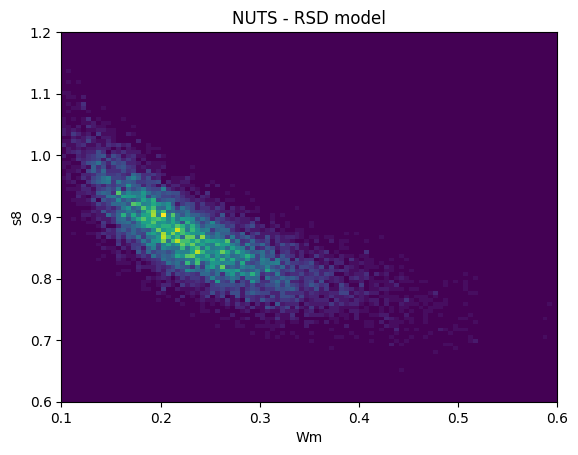

In [26]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");